In [2]:
import math
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

C:\Users\0x6f736f646f\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\0x6f736f646f\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.
C:\Users\0x6f736f646f\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
data = pd.read_csv("../Data/DIS.csv", header=None, index_col=None) #Reading the dataset

In [7]:
data.head(4) # Checking the dataset head

,0,1,2,3,4,5,6
0,1996-12-31,23.011177,23.175543,22.805719,22.928993,17.804647,2719200
1,1997-01-02,22.928993,22.970085,21.942801,22.148258,17.198397,8115400
2,1997-01-03,22.394806,22.805719,22.394806,22.764629,17.677013,4650000
3,1997-01-06,22.764629,22.928993,22.559172,22.682446,17.613201,3623300


In [9]:
all_y = data[5].values # Close price
all_y.shape

(5035,)

In [11]:
dataset = all_y.reshape(-1, 1)

In [12]:
dataset.shape

(5035, 1)

In [13]:
print(all_y[30])
print(dataset[30])

19.590878
[19.590878]


In [14]:
# normalize the dataset between 1 and 0
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [19]:
# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [22]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look-1):
        a = dataset[i:(i+look), 0]
        dataX.append(a)
        dataY.append(dataset[i + look, 0])
    return np.array(dataX), np.array(dataY)

In [23]:
# reshape into X=t and Y=t+1, timestep 240
look = 240
trainX, trainY = create_dataset(train, look)
testX, testY = create_dataset(test, look)

In [29]:
print(trainX[0][0])
print(dataset[0])

0.06413302697143405
[0.06413303]


In [30]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=240, verbose=1)

W0816 22:43:32.739599 16248 deprecation.py:506] From c:\users\0x6f736f646f\documents\keras\keras\backend\tensorflow_backend.py:3721: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/10
2276/2276 [==============================] - 2s 928us/step - loss: 0.0022
Epoch 2/10
2276/2276 [==============================] - 0s 33us/step - loss: 0.0011
Epoch 3/10
2276/2276 [==============================] - 0s 33us/step - loss: 7.3601e-04
Epoch 4/10
2276/2276 [==============================] - 0s 35us/step - loss: 5.8688e-04
Epoch 5/10
2276/2276 [==============================] - 0s 34us/step - loss: 4.9581e-04
Epoch 6/10
2276/2276 [==============================] - 0s 32us/step - loss: 4.3768e-04
Epoch 7/10
2276/2276 [==============================] - 0s 37us/step - loss: 3.8073e-04
Epoch 8/10
2276/2276 [==============================] - 0s 32us/step - loss: 3.6705e-04
Epoch 9/10
2276/2276 [==============================] - 0s 33us/step - loss: 3.3797e-04
Epoch 10/10
2276/2276 [==============================] - 0s 32us/step - loss: 3.2063e-04


In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [33]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [34]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.56 RMSE
Test Score: 17.58 RMSE


In [75]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look:len(trainPredict)+look, :] = trainPredict

In [76]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look*2)+1:len(dataset)-1, :] = testPredict

testPrices:


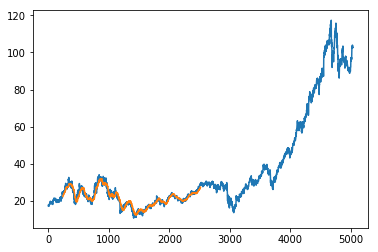

In [78]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look:])

In [79]:
print('testPredictions:')
print(testPredict)

testPredictions:
[[27.828169]
 [27.7606  ]
 [27.743382]
 ...
 [65.02463 ]
 [65.36354 ]
 [65.98668 ]]


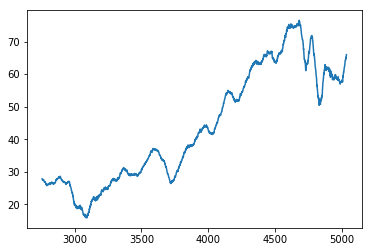

In [80]:
# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.show()